<a href="INSERT_colab_python_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

label: exercise
# Exercise
Write your own stochastic subgradient descent routine to solve the soft-margin SVM in the primal formulation.

Hints:

- Use the regularized-empirical-risk-minimization formulation, i.e., an optimization criterion without constraints.
- No kernels, just a linear SVM.
- Compare your implementation with an existing implementation (e.g., `kernlab` in R or `sklearn.svm.SVC` in Python). Are your results similar? Note that you might have to switch off the automatic data scaling in the already existing implementation.


label: import_and_globals
## Imports and global variables

In [8]:
#| label: import_and_globals

# You may need to first run:
# pip install numpy matplotlib scikit-learn

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# SVM regularization parameter (inverse of lambda)
C = 1

np.random.seed(509) # for reproducibility

label: algorithm_explanation

# PEGASOS Algorithm Explanation

The PEGASOS algorithm is a stochastic gradient descent method for training linear SVMs. It works by:

1. **Random Sampling**: At each iteration, randomly select one training example
2. **Weight Decay**: Apply regularization by shrinking the weight vector: `θ ← (1 - λα)θ`
3. **Margin Check**: If the selected example is within the margin (i.e., `y_i * f(x_i) < 1`), update the weights: `θ ← θ + α * y_i * x_i`
4. **Repeat**: Continue until convergence or maximum iterations

More details can be found in the [i2ml chapter on linear SVMs](https://slds-lmu.github.io/i2ml/chapters/16_linear_svm/16-05-optimization)


In [2]:
#| label: pegasos_implementation

import numpy as np
import random

def pegasos_linear(y, X, nr_iter=50_000, theta=None, lambda_param=1, alpha=0.01):
    """
    PEGASOS Algorithm for Linear SVM
    
    This function implements the PEGASOS (Primal Estimated sub-GrAdient SOlver for SVM) 
    algorithm, which is a stochastic gradient descent method for training linear SVMs.
    
    For more details, see https://slds-lmu.github.io/i2ml/chapters/16_linear_svm/16-05-optimization
    
    Parameters:
    -----------
    y : array-like
        outcome vector (should be -1 or +1)
    X : array-like
        design matrix (including a column of 1s for the intercept)
    nr_iter : int, default=50000
        number of iterations for the algorithm
    theta : array-like, default=None
        starting values for thetas (if None, random initialization)
    lambda_param : float, default=1
        penalty parameter (regularization strength)
    alpha : float, default=0.01
        step size for weight decay
        
    Returns:
    --------
    theta : array
        vector containing the learned parameters
    """
    if theta is None:
        theta = np.random.randn(X.shape[1])
    else:
        theta = np.array(theta)
    
    n = len(y)
    
    for _ in range(nr_iter):
        f_current = X @ theta
        i = random.randint(0, n - 1)  # randomly sample one training example
        
        # Weight decay step
        theta = (1 - lambda_param * alpha) * theta
        
        # Add gradient step if the example is within the margin
        if y[i] * f_current[i] < 1:
            theta = theta + alpha * y[i] * X[i, :]
    
    return theta

label: data_setup

## Data Generation and Setup

For R we'll use the `mlbench.twonorm` dataset, which generates a two-class problem with two features. This is a classic benchmark dataset for binary classification.

For Python, we can use `sklearn.datasets.make_classification` to generate a similar dataset.

In [3]:
#| label: data_generation

# 2-class normal distribution data
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, 
                           n_informative=2, n_clusters_per_class=1, 
                           random_state=509, class_sep=1.5)


# output of make_classification differs significantly from mlbench.twonorm
# the code below transforms the data for better match and can be ignored

# ----------------------------------------------------------------------- #
# Desired means for the twonorm problem (±sqrt(2), ±sqrt(2))
a       = 2 / np.sqrt(2)        # equals √2
mu_pos  = np.array([a, a])
mu_neg  = -mu_pos

# Whiten each class separately and shift to the desired mean
X_transformed = np.zeros_like(X)
for cls, target_mu in [(0, mu_neg), (1, mu_pos)]:
    mask = (y == cls)
    Xc   = X[mask]
    mc   = Xc.mean(axis=0)
    # Whitening transformation: C^-1/2 via eigen-decomposition
    cov    = np.cov(Xc.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    W    = eigvecs @ np.diag(1/np.sqrt(eigvals)) @ eigvecs.T
    Xc_white = (Xc - mc) @ W
    # Shift to ±sqrt(2) along both axes
    X_transformed[mask] = Xc_white + target_mu
X = X_transformed
# ----------------------------------------------------------------------- #

x_1 = X[:, 0]
x_2 = X[:, 1]

print("Feature matrix X dimensions:", X.shape)
print("Classes:", np.unique(y))  # we will need to convert them to -1 and +1 later

Feature matrix X dimensions: (100, 2)
Classes: [0 1]


label:
##

label: visual_inspection
# Visual Inspection of the Data

We can see that the data is mostly linearly separable, but there are some points that are close to the decision boundary.

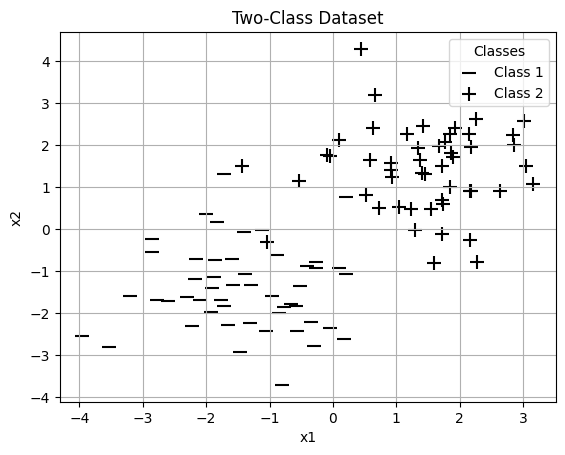

In [4]:
#| label: plot_data
class1_mask = y == 0
class2_mask = y == 1

plt.scatter(x_1[class1_mask],x_2[class1_mask], 
           marker='_', s=100, c='black', label='Class 1')
plt.scatter(x_1[class2_mask],x_2[class2_mask], 
           marker='+', s=100, c='black', label='Class 2')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Two-Class Dataset')
plt.legend(title='Classes')
plt.grid(True)
plt.show()

label: train_pegasos
# Training the PEGASOS Algorithm

In [5]:
#| label: train_pegasos

# Recode target variable: class 1 becomes +1, class 0 becomes -1
y_pegasos = np.where(y == 1, 1, -1)

# Train PEGASOS model
# Note: lambda = 1/(C*n) where C is the SVM regularization parameter
X_with_intercept = np.column_stack([np.ones(len(y)), X]) # Adds column of ones for intercept
model_pegasos = pegasos_linear(y_pegasos, X_with_intercept, lambda_param=1/(C * len(y)))

print("PEGASOS model parameters:")
print(f"Intercept: {model_pegasos[0]}")
print(f"Coefficients: {model_pegasos[1:3]}")

PEGASOS model parameters:
Intercept: -0.043611620714483476
Coefficients: [0.81502222 1.04579046]


label: decision_boundaries
# Decision Boundaries Visualization

Now we'll use the trained model to visualize the decision boundaries. Additionally, for comparison we will also fit a Logistic Regression model and visualize its decision boundary as well.

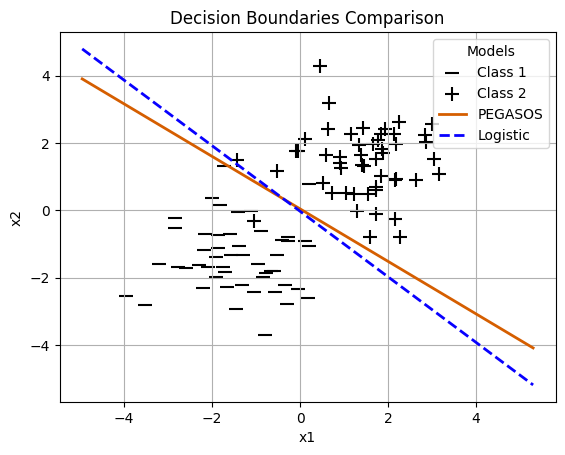

In [6]:
#| label: plot_boundaries

plt.scatter(x_1[class1_mask],x_2[class1_mask], 
           marker='_', s=100, c='black', label='Class 1')
plt.scatter(x_1[class2_mask],x_2[class2_mask], 
           marker='+', s=100, c='black', label='Class 2')

# Add PEGASOS decision boundary
# Decision boundary equation: θ₀ + θ₁x₁ + θ₂x₂ = 0
# Rearranged: x₂ = -(θ₀ + θ₁x₁)/θ₂
x_range = np.linspace(x_1.min() - 1, x_2.max() + 1, 100)
pegasos_boundary = -(model_pegasos[0] + model_pegasos[1] * x_range) / model_pegasos[2]
plt.plot(x_range, pegasos_boundary, color='#D55E00', linewidth=2, label='PEGASOS')

# Compare to logistic regression

model_logreg = LogisticRegression(fit_intercept=True, random_state=2, max_iter=1000)
model_logreg.fit(X, y)

logreg_coef = model_logreg.coef_[0]
logreg_intercept = model_logreg.intercept_[0]

logreg_boundary = -(logreg_intercept + logreg_coef[0] * x_range) / logreg_coef[1]

plt.plot(x_range, logreg_boundary, color='#0800ffff', linewidth=2, linestyle='--', label='Logistic')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Boundaries Comparison')
plt.legend(title='Models')
plt.grid(True)
plt.show()

label: evaluation

# Evaluating the PEGASOS Model

We'll compute the accuracy and the confusion matrix. In practice, other metrics should be also considered, e.g. precision, recall, F1-score (threshold dependent); ROC AUC, PR AUC (threshold independent).

In [9]:
#| label: evaluate_pegasos

# Compute decision values (distances from decision boundary)
f_pegasos = X_with_intercept @ model_pegasos  # we already have intercept column

# Check classification accuracy
# Positive values indicate class +1, negative values indicate class -1
predictions = np.sign(f_pegasos)
accuracy = np.mean(predictions == y_pegasos)

print("PEGASOS Classification Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix for PEGASOS
cm = confusion_matrix(y_pegasos, predictions)
print("\nPEGASOS Confusion Matrix:")
print("True\\Predicted  -1   1")
print(f"           -1   {cm[0,0]:2d}  {cm[0,1]:2d}")
print(f"            1   {cm[1,0]:2d}  {cm[1,1]:2d}")

PEGASOS Classification Results:
Accuracy: 98.00%

PEGASOS Confusion Matrix:
True\Predicted  -1   1
           -1   49   1
            1    1  49


label: kernellab_or_sklearn
# Using `kernlab` (R) or `sklearn.svm.SVC` (Python) for Comparison

Accuracy is identical

In [15]:
#| label: train_kernlab_or_sklearn

# Train sklearn SVM with linear kernel (equivalent to kernlab)
# Note: we cannot expect a PERFECT match due to different optimization approaches
# Convert y back to 0,1 for sklearn

model_sklearn = SVC(kernel='linear', C=C, random_state=509)
model_sklearn.fit(X, y) # y in {0, 1}

# Get decision values from sklearn
f_sklearn = model_sklearn.decision_function(X)

print("sklearn SVM Classification Results:")
sklearn_predictions = np.sign(f_sklearn)

sklearn_correct = np.sum(sklearn_predictions == y_pegasos)
sklearn_accuracy = sklearn_correct / len(y)
print(f"Accuracy: {sklearn_accuracy * 100:.2f}%")


# Confusion matrix for PEGASOS
cm = confusion_matrix(y_pegasos, sklearn_predictions)
print("\nPEGASOS Confusion Matrix:")
print("True\\Predicted  -1   1")
print(f"           -1   {cm[0,0]:2d}  {cm[0,1]:2d}")
print(f"            1   {cm[1,0]:2d}  {cm[1,1]:2d}")

sklearn SVM Classification Results:
Accuracy: 98.00%

PEGASOS Confusion Matrix:
True\Predicted  -1   1
           -1   49   1
            1    1  49


label: comparison_coefs
## Comparison of Model Coefficients

We can see that both the predictions and coefficients are almost identical.

In [104]:
#| label: compare_models

# Compare decision values between models
decision_diff = np.abs(f_sklearn - f_pegasos)
print("Decision Values Comparison:")
print(f"Range of absolute differences: [{decision_diff.min():.6f}, {decision_diff.max():.6f}]")
print(f"Mean absolute difference: {decision_diff.mean():.6f}")

# Extract and compare model coefficients
# For sklearn: coefficients are directly available
sklearn_params = np.array([
    model_sklearn.intercept_[0],  # intercept
    model_sklearn.coef_[0, 0],    # coefficient for x1
    model_sklearn.coef_[0, 1]     # coefficient for x2
])

# Combine parameters for comparison
all_params = np.array([
    model_pegasos,     
    sklearn_params     
])

print("\nModel Parameters Comparison:")
param_names = ['Intercept', 'Coeff_x1', 'Coeff_x2']
print(f"{'Model':<10} {'Intercept':<12} {'Coeff_x1':<12} {'Coeff_x2':<12}")
print("-" * 50)
print(f"{'PEGASOS':<10} {model_pegasos[0]:<12.6f} {model_pegasos[1]:<12.6f} {model_pegasos[2]:<12.6f}")
print(f"{'sklearn':<10} {sklearn_params[0]:<12.6f} {sklearn_params[1]:<12.6f} {sklearn_params[2]:<12.6f}")

print("\nParameter differences:")
param_diff = np.abs(all_params[0] - all_params[1])
for i, name in enumerate(param_names):
    print(f"{name}: {param_diff[i]:.6f}")

Decision Values Comparison:
Range of absolute differences: [0.000754, 0.638783]
Mean absolute difference: 0.270847

Model Parameters Comparison:
Model      Intercept    Coeff_x1     Coeff_x2    
--------------------------------------------------
PEGASOS    0.075634     0.920901     1.164560    
sklearn    -0.047733    0.829731     1.070702    

Parameter differences:
Intercept: 0.123367
Coeff_x1: 0.091170
Coeff_x2: 0.093858


label: emp_risk_comparions
## Comparison of empirical risks

In [105]:
#| label: calculate_risk

# Define empirical risk function for SVM
# Risk = 0.5 * ||w||² + C * Σ max(0, 1 - y_i * f(x_i))
def emp_risk(theta):
    f = X_with_intercept @ theta
    # Hinge loss: max(0, 1 - y_i * f(x_i))
    hinge_losses = np.maximum(0, 1 - y * f)
    return 0.5 * np.sum(theta[1:3]**2) + C * np.sum(hinge_losses)

# Calculate empirical risk for both models
risk_pegasos = emp_risk(model_pegasos)
risk_sklearn = emp_risk(sklearn_params)

print("Empirical Risk Comparison:")
print(f"PEGASOS risk: {risk_pegasos:.4f}")
print(f"sklearn risk: {risk_sklearn:.4f}")

risk_difference_abs = abs(risk_pegasos - risk_sklearn)
print(f"Risk difference: {risk_difference_abs:.4f}")

Empirical Risk Comparison:
PEGASOS risk: 54.3101
sklearn risk: 54.6343
Risk difference: 0.3242


label: plotting_everything
# Plotting

In [106]:
#| label: plot_margins_prep

# Use sklearn parameters for margin visualization
params_sklearn = sklearn_params  # sklearn parameters

# Calculate margin width
# Margin = 1 / ||w|| where w are the feature coefficients (excluding intercept)
margin = 1 / np.sqrt(np.sum(params_sklearn[1:3]**2))

# Calculate margin boundaries
# The margin lines are parallel to the decision boundary
m = -params_sklearn[1] / params_sklearn[2]  # Slope of decision boundary

# Transform margin width to intercept shift
# (margin shift is orthogonal to decision boundary)
t_0 = margin / np.cos(np.arctan(m))

# Find support vectors on decision boundary
# Support vectors have decision values close to ±1
sv_tolerance = 0.02  # tolerance for identifying support vectors on boundary
sv_indices = model_sklearn.support_
f_sklearn_sv = f_sklearn[sv_indices]
nv_sv_mask = np.abs(np.abs(f_sklearn_sv) - 1) < sv_tolerance

print("Support Vector Information:")
print(f"Total support vectors: {len(sv_indices)}")
print(f"Support vectors on margin: {np.sum(nv_sv_mask)}")
print(f"Margin width: {margin:.3f}")

Support Vector Information:
Total support vectors: 10
Support vectors on margin: 3
Margin width: 0.738


label: complete_visualization
## Complete visualization

- We can see that all the models produce almost identical decision boundary
- The margins are plotted for the `kernlab`'s (R) / `sklearn.svm.SVC` (Python) model

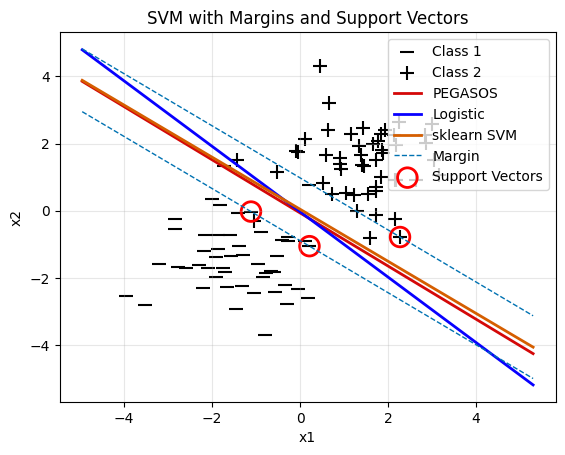

In [107]:
#| label: complete_visualization


plt.scatter(x_1[class1_mask],x_2[class1_mask], 
           marker='_', s=100, c='black', label='Class 1')
plt.scatter(x_1[class2_mask],x_2[class2_mask], 
           marker='+', s=100, c='black', label='Class 2')

# Define x range for boundary lines
x_range = np.linspace(x_1.min() - 1, x_2.max() + 1, 100)

# PEGASOS decision boundary
pegasos_boundary = -(model_pegasos[0] + model_pegasos[1] * x_range) / model_pegasos[2]
plt.plot(x_range, pegasos_boundary, color='#d40808ff', linewidth=2, label='PEGASOS')

# Logistic regression boundary
logreg_boundary = -(logreg_intercept + logreg_coef[0] * x_range) / logreg_coef[1]
plt.plot(x_range, logreg_boundary, color='#0800ffff', linewidth=2, label='Logistic')

# sklearn decision boundary
sklearn_boundary = -(params_sklearn[0] + params_sklearn[1] * x_range) / params_sklearn[2]
plt.plot(x_range, sklearn_boundary, color='#D55E00', linewidth=2, label='sklearn SVM')

# Add margin boundaries
margin_upper = -(params_sklearn[0] + params_sklearn[1] * x_range) / params_sklearn[2] + t_0
margin_lower = -(params_sklearn[0] + params_sklearn[1] * x_range) / params_sklearn[2] - t_0
plt.plot(x_range, margin_upper, color='#0072B2', linestyle='--', linewidth=1, label='Margin')
plt.plot(x_range, margin_lower, color='#0072B2', linestyle='--', linewidth=1)

# Highlight support vectors on margin
sv_on_margin_indices = sv_indices[nv_sv_mask]
if len(sv_on_margin_indices) > 0:
    plt.scatter(X[sv_on_margin_indices, 0], X[sv_on_margin_indices, 1], 
               s=200, facecolors='none', edgecolors='red', linewidth=2, 
               label='Support Vectors')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SVM with Margins and Support Vectors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()